# Claculate distance of traffic light

In [67]:
import sys
import os
import pickle
from matplotlib.pyplot import imread
import numpy as np
#import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt

In [69]:
with open('data.pkl', 'rb') as pklfile:
    data = pickle.load(pklfile,fix_imports=True,encoding='latin1')
focal_length = data['flx']
pp = data['principle_point']
EM = data['egomotion_18-19']
points_18 = data['points_18']
points_19 = data['points_19']
foe = EM[:3, 3] / EM[2, 3]
foe[:2] *= focal_length
print(pp)
R = EM[0:3, 0:3]
tz = EM[2, 3]

[1096.98   513.137]


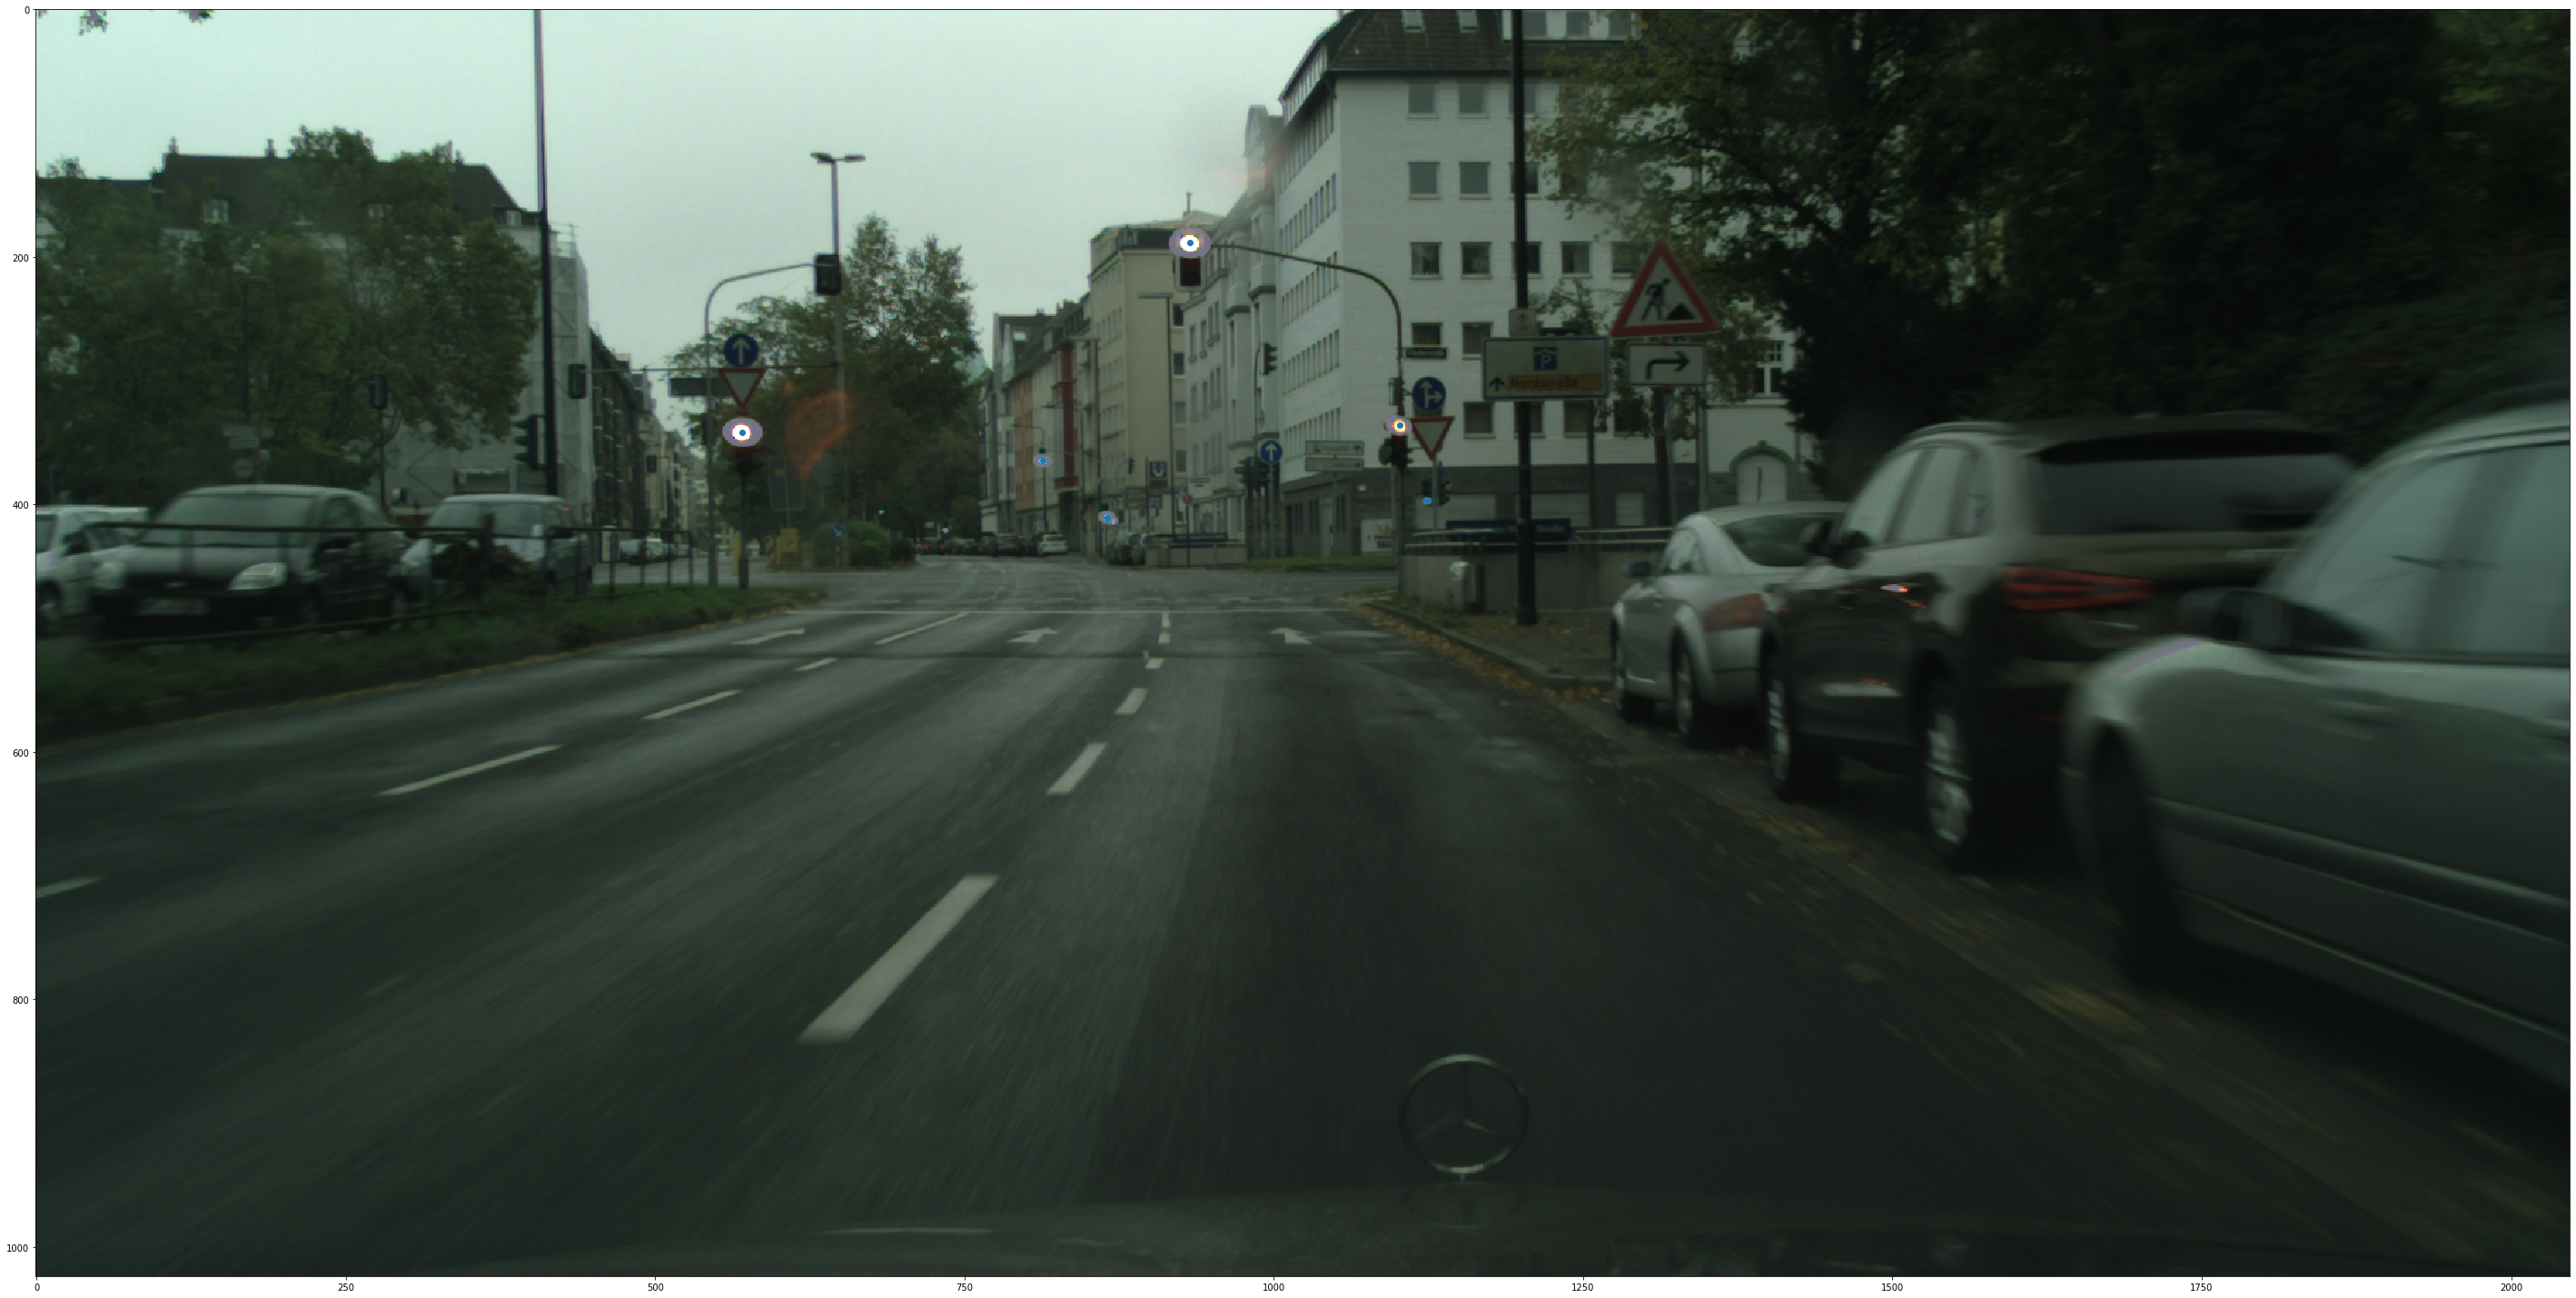

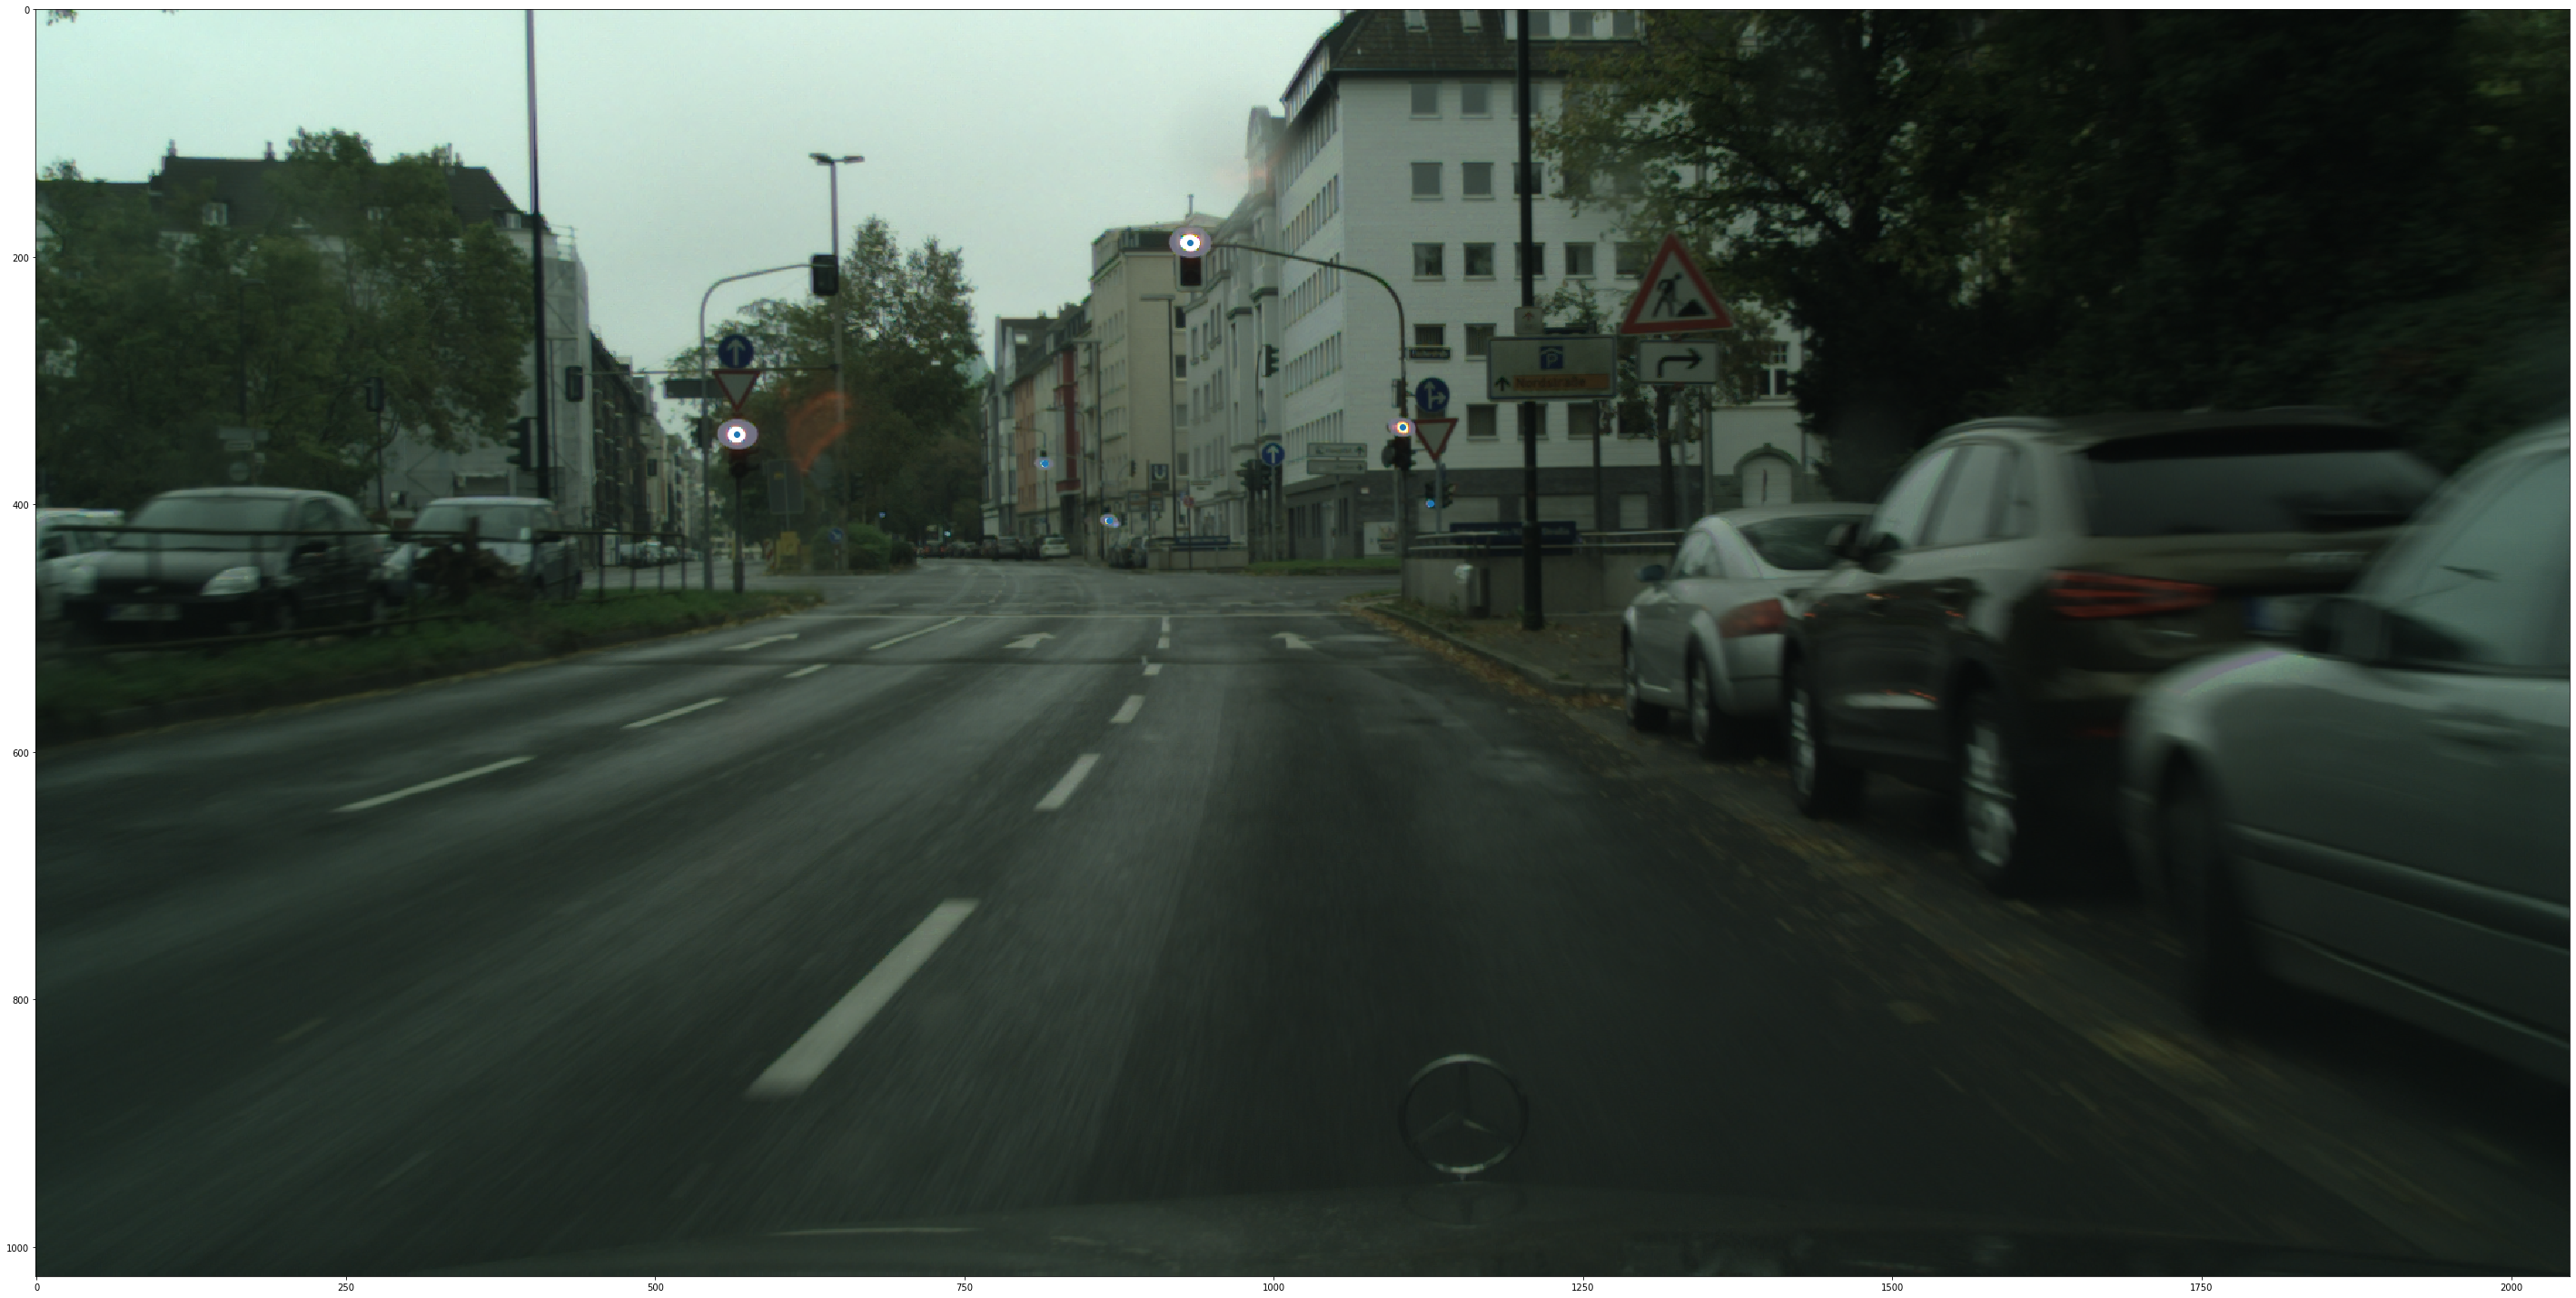

In [9]:
with open('dusseldorf_000049_000018_leftImg8bit.png', 'br') as imgfile:
    img1 = plt.imread(imgfile)
with open('dusseldorf_000049_000019_leftImg8bit.png', 'br') as imgfile:
    img2 = plt.imread(imgfile)

plt.figure('frame 18', figsize = (50,50))
plt.imshow(img1)
plt.scatter(points_18[0][:, 0], points_18[0][:, 1])
plt.figure('frame 19', figsize = (50,50))
plt.imshow(img2)
plt.scatter(points_19[0][:, 0], points_19[0][:, 1])
plt.show()

In [10]:
def delta_points(points):
    pointsXY = points[0]
    for point in pointsXY:
        point[0] = point[0] - pp[0]
        point[1] = point[1] - pp[1]
    return pointsXY
dlt_points18 = delta_points(points_18)
dlt_points19 = delta_points(points_19)
print(dlt_points18)
print(dlt_points19)


[[-526.98  -171.137]
 [-164.98  -325.137]
 [   5.02  -177.137]
 [-283.48  -148.637]
 [-231.48  -102.637]
 [  27.02  -116.137]]
[[-530.98  -170.137]
 [-164.98  -325.137]
 [   7.02  -176.137]
 [-282.48  -146.137]
 [-229.98  -100.137]
 [  29.52  -114.137]]


## Rotate lights in previous image

In [11]:
points_FL =[]
for point in dlt_points18:
    points_FL.append(np.append(point, focal_length))
    
print(points_FL[0])  

[-526.98      -171.137     2263.9108953]


In [12]:
def abc_pxl(EM, xyf):
    abc = R.dot(xyf)
    return abc

In [13]:
def rotated_pxl(abc):
    x_rot = (abc[0] / abc[2]) * focal_length
    y_rot = (abc[1] / abc[2]) * focal_length
    return x_rot, y_rot

In [14]:
xy_rot=[]
for xyf in points_FL:
    xy_rot.append(rotated_pxl(abc_pxl(EM,xyf)))
    
print(xy_rot)


[(-525.056953426423, -168.4468690425896), (-163.1867177795857, -322.47708942781986), (6.799391954640064, -174.55922640983232), (-281.64675831455526, -146.0045693377051), (-229.65824830525133, -100.0246991923807), (28.807921625542452, -113.57223255374602)]


## Compute epipolar lines for lights in current image

In [25]:
def epipolar_line(p):
    m = (foe[1] - p[1]) / (foe[0] - p[0])
    n = ((p[1]*foe[0] - foe[1]*p[0]) / (foe[0] - p[0]))
    return m, n


## Match rotated points to current points

In [26]:
def dist(m, n, point):
    dist = abs((m * point[0] + n - point[1]) / math.sqrt(m ** 2 + 1))
    return dist

In [38]:
def match_points(xy_rot, current_points):
    matches = []
    for current_xy in current_points:
        m, n = epipolar_line(current_xy)
        distances = [dist(m, n, xy) for xy in xy_rot] 
        rot_match_point = xy_rot[distances.index(min(distances))] 
        match = []
        match.append(tuple(current_xy))
        match.append(rot_match_point)
        matches.append(match)
    return matches    
        
matches = match_points(xy_rot, dlt_points19)
matches

[[(-530.98, -170.13699999999994), (-525.056953426423, -168.4468690425896)],
 [(-164.98000000000002, -325.13699999999994),
  (-163.1867177795857, -322.47708942781986)],
 [(7.019999999999982, -176.13699999999994),
  (6.799391954640064, -174.55922640983232)],
 [(-282.48, -146.13699999999994), (-281.64675831455526, -146.0045693377051)],
 [(-229.98000000000002, -100.13699999999994),
  (-229.65824830525133, -100.0246991923807)],
 [(29.519999999999982, -114.13699999999994),
  (28.807921625542452, -113.57223255374602)]]

## Calculate Z distance from tracking

In [76]:
def zx_distance(match):
    z = (tz * (foe[0] - match[1][0])) / (match[0][0] - match[1][0])
    return z 

def zy_distance(match):
    z = (tz * (foe[1] - match[1][1])) / (match[0][1] - match[1][1])
    return z 

## 3D position

In [77]:
D3_positions = []
for light in matches:
    x = light[0][0] + pp[0]
    y = light[0][1] + pp[1]
    zx = zx_distance(light)
    zy = zy_distance(light)
    D3_positions.append((x, y, zy))
print(D3_positions)    

[(566.0, 343.0, 31.617296212730484), (932.0, 188.0, 54.09820223852875), (1104.0, 337.0, 36.143995760196745), (814.5, 367.0, 303.98878997250415), (867.0, 413.0, 118.02530009547422), (1126.5, 399.0, 37.55624454937361)]


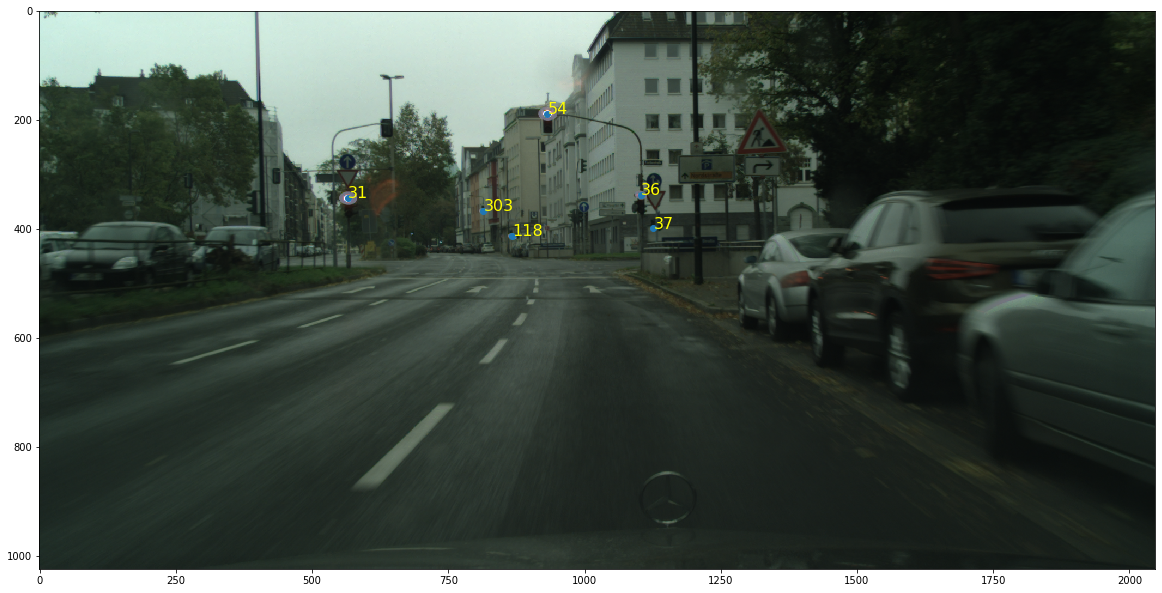

In [78]:
style = dict(size=16, color='yellow')
plt.figure(figsize = (20, 20))
plt.imshow(img2)
plt.scatter(points_19[0][:, 0], points_19[0][:, 1])
for i in range(len(D3_positions)):
    plt.annotate(int(D3_positions[i][2]),(D3_positions[i][0], D3_positions[i][1]), **style)
plt.show()    